<h1> K-NN Regression vs Linear Regression: Predicting a Tennis Player's Prize Money Based on Their Best Rank</h1>

<h2> Background Information </h2>
    
<p> In DSCI 100, we have learned about two ways to predict outcomes from a dataset: classification and regression. Classification is the type of prediction one would use to predict a category. Regression, on the other hand, is used to predict continuous variables. Regression includes two types: k-nn regression and linear regression. Each are useful for different instances: k-nn for non-linear data, and linear for more linear data and to predict past the dataset.
    
Tennis is asport where a player earns their salarybread mainly through the prize money (excluding endorsements, TV ads, etc.). On average, the top 5 players make around $8 million per year, whereas the players between 50-100 rank get around half a million dollars. This gives us a clear idea that being a professional tennis player is only a profitable profession when you are in the top ranks.</p>

<h2> Purpose </h2>
<p> The purpose of our project is to a) predict how much prize money a pro tennis player can earn given their best rank number, and b) run both k-nn and linear regression models on our data to determine which model best suits our dataset and why. The dataset that will be used to achieve this is the 500 Tennis Players’ Statistics dataset from the Ultimate Tennis Statistics website. The algorithms that will be used are both k-nn regression and linear regression. This is because the variable we want to predict is not categorical. The target variable will be the prize money column and our predictor will be the best rank column of the dataset. Based on the sources we have referred to, they suggest that better performance results in higher prize money. Thus we expect to see that the better the ranking (a lower rank number), the higher the prize money in US dollars.</p>

[Link to Top 500 Tennis Players' Statistics](https://www.ultimatetennisstatistics.com/tournamentEvents)

In [1]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(digest)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h2>Loading and Wrangling Data</h2>

<p>Before we begin our analysis and forming models, we want to tidy our data, so that our packages work smoothly on our dataset. We first load the url onto the Jupyter Notebook under the name player_stats.

We select the Best Rank column and Prize Money column and get rid of the NAs in the code. All other columns aren’t used. We turned the columns that needed to be numerical into numerical columns. In our dataset, the prize money was spaced in a way in which we could not use it as it was. So in the code we mutate the column by breaking down the entire number into millions, thousands, and hundreds columns and then rejoining them again.

Finally, we plot our now tidy dataset with a scatterplot to visualize the relationship between Best Rank and Prize Money. Because we wanted our scales to be readable, our y-axis scale is in thousands, with the axis title showing that each prize money value is x $1000. 

Based on Figure 1 (below), we see a downward exponential trend as a relationship between Best Rank and Prize Money. The better the rank, the higher the prize money, as expected. From this plot, we can also gather that k-nn will most likely work better for this model given that it is not a linear or near-linear relationship. However, we will still show both forms of regression to visually see which one works best. </p>

In [2]:
# setting seed
set.seed(1552)

# load data
player_stats <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

# tidy data
players_tidy <- player_stats|>
    separate(col = "Best Rank",
             into = c("best_rank", 
                   "Best_rank_day", "Best_rank_month", "Best_rank_year"),
            convert = TRUE) |>
    select(-Best_rank_day, -Best_rank_month) |>
    rename("prize_money" = "Prize Money")|>
    separate(prize_money, c(NA, "millions", "thousands", "hundreds"))|>
    mutate(millions = as.numeric(millions))|>
    mutate(thousands = as.numeric(thousands))|>
    mutate(hundreds = as.numeric(hundreds))|>
    mutate(millions = millions * 1000000)|>
    mutate(thousands = thousands * 1000)|>
    mutate(prize_money = millions + thousands + hundreds)|>
    mutate(prize_money= prize_money/1000)|>
    select(prize_money, best_rank)|>
    na.omit()

#scatterplot best rank vs. prize money
options(repr.plot.width = 15, repr.plot.height = 10)

players_plot<-players_tidy|>
    ggplot(aes(x = best_rank, y = prize_money))+
    geom_point()+
    labs(x = "Best Rank", y = "Prize Money (x $1000)")+
    ggtitle("Figure 1: Prize Money Vs Player's Best Rank")+
    ylim(0,40000)+
    xlim(0,150)+
    theme(text = element_text(size = 20))


New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 4 pieces. Additional pieces discarded in 499 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 4 pieces. Additional pieces discarded in 21 rows [16, 96, 128, 142, 208, 212, 228, 267, 274, 337, 363, 364, 381, 394, 414, 423, 435, 436, 461, 468, ...].”
Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 264 rows [2, 4, 7, 8, 9, 10, 13, 14, 15, 18, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, ...].”


In [3]:
player_stats

...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


**Table 1.0: Top 500 Tennis Players' Statistics Dataset**

In [4]:
 players_tidy

prize_money,best_rank
<dbl>,<int>
3261.567,44
6091.971,17
1517.157,31
⋮,⋮
1703.096,58
1048.314,74
22132.368,4


 **Table 1.1: Tidied dataframe**

Warning message:
“Removed 4 rows containing missing values (geom_point).”


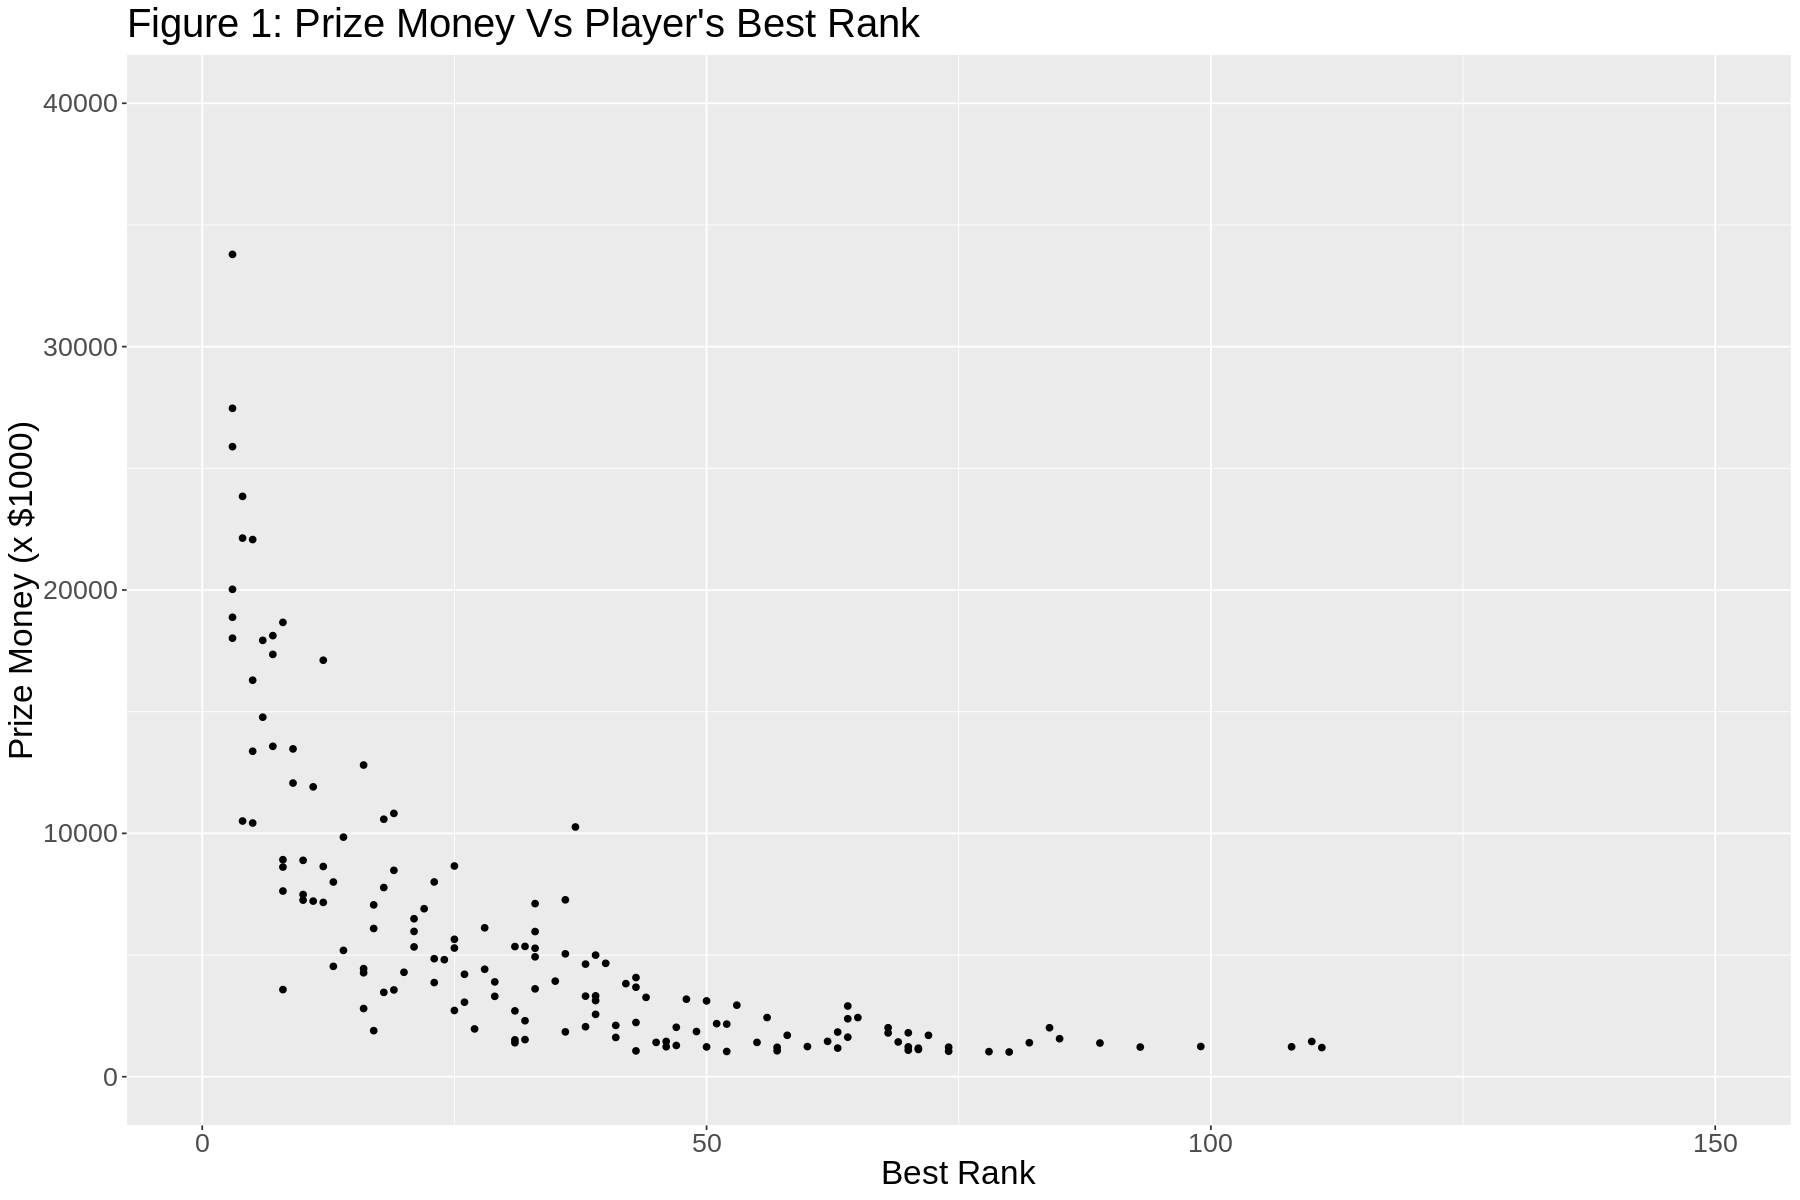

In [5]:
players_plot

<h2> K-nn Regression Model</h2>

<p>For our first model, we will be using the K-nearest neighbor regression algorithm with our data to calculate the RSMPE of this model to be compared to the RSMPE of the linear regression model. Because we are predicting numerical values, we would be approaching the data with regression instead of classification. 

Our responding variable is the amount of prize money earned by a tennis player in dollars (prize_money), to be predicted by the players’ best rank (best_rank).

Before performing the k-nn regression, the data has been loaded and cleaned, and the seed has been set. Then we split the data into players_training and players_testing to prevent the model from overfitting. We will use players_training as our training set when we are building the model and players_testing as our testing set for when we are evaluating the model.
</p>

In [6]:
set.seed(4242)

#splitting data
players_split<-initial_split(players_tidy, prop = 0.75, strata = prize_money)
players_training<-training(players_split)
players_testing<-testing(players_split)

<p>Our prediction will be made using neighboring points. To select K, we will perform cross-validation following the RMSPE formula which differentiates K-nn regression from K-nn classification. To do this we need to create a recipe which specifies
the prize-money as our responding variable and best_rank as our predictor variable. Because we are using only 1 predictor, it is unnecessary to perform scaling, but for precautionary measures we will scale. We then set the model specification to perform K-nn regression.
</p>

In [7]:
#recipe
players_recipe<-recipe(prize_money ~ best_rank, data = players_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

#model specification
players_spec<-nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("regression")

<p>The recipe and the model specification is then combined in the workflow. Here is also where we initiate a 5-fold cross-validation object:</p>

In [8]:
#making workflow
set.seed(4205)
players_vfold<-vfold_cv(players_training, v = 5, strata = prize_money)

players_fit<-workflow()|>
    add_recipe(players_recipe)|>
    add_model(players_spec)|>
    fit(players_training)

Warning message:
“tune samples were requested but there were 115 rows in the data. 110 will be used.”


<p>Using our workflow and the RMSPE, we find the best K by testing 50 values of K. We want our workflow to test all the values of K and perform resampling. The best K will have the minimum RMSPE value.</p>

In [14]:
#knn regression metrics
set.seed(3764)
gridvals<-tibble(neighbors = seq(1, 50))

players_results<- players_fit|>
    tune_grid(resamples = players_vfold, grid = gridvals)|>
    collect_metrics()

#arranging metrics to find minimum RMSPE value
players_min<-players_results|>
    filter(.metric == "rmse")|>
    arrange(std_err)|>
    slice(1)

In [15]:
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,7558.0817145,5,2.070785e+03,Preprocessor1_Model01
1,rsq,standard,0.6807709,5,9.185236e-02,Preprocessor1_Model01
2,rmse,standard,5913.7306939,5,1.834785e+03,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,rsq,standard,4.004500e-01,5,8.669204e-02,Preprocessor1_Model49
50,rmse,standard,1.242536e+04,5,4.933862e+03,Preprocessor1_Model50
50,rsq,standard,3.946393e-01,5,8.372357e-02,Preprocessor1_Model50


**Table 2.0: K-nn Regression Workflow Results**

In [16]:
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,5913.731,5,1834.785,Preprocessor1_Model02


**Table 2.1: Minimum RMSPE value**

 <p>From Table 2.1 (above), we found the K = 2 to be the best value for K. So now, we need to retrain our model using the K-value which gave us the minimum RMSPE. 
    
Finally, let’s evaluate our model by fitting it onto our testing set (players_testing). Using the predict() function, we make predictions on the test data and get a summary of how well our regression model did. Table 2.2 (below) tells us that our K-nn regression model resulted in an RMSPE value of $8130.85 (rounded to the nearest cent).</p>

In [18]:
# retraining model on training set with best
players_spec_best<-nearest_neighbor(weight_func = "rectangular", neighbors = 2)|>
    set_engine("kknn")|>
    set_mode("regression")

players_fit_best<-workflow()|>
    add_recipe(players_recipe)|>
    add_model(players_spec_best)|>
    fit(data = players_training)

# making predictions on testing data
players_summary<-players_fit_best|>
    predict(players_testing)|>
    bind_cols(players_testing)|>
    metrics(truth = prize_money, estimate = .pred)

# rmspe for testing set 
rmspe_testing<-players_summary|>
    filter(.metric == "rmse")|>
    select(.estimate)|>
    pull()

In [19]:
players_summary
rmspe_testing

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8130.8469042
rsq,standard,0.9570247
mae,standard,2959.2685625


[1] 8130.847

**Table 2.2: Prediction on Testing Data**

<h3>Now let’s perform linear regression to determine which model is the better fit for this prediction problem.</h3>  

<h2>Linear Regression Model</h2>
<p>Using the results from performing linear regression, we will determine the RMSPE and compare it to the RMSPE from the k-nn regression model performed. The lowest RMSPE will tell us which model better fits our data for the relationship we are looking at and what we want to predict. Using the model that best fits our data, we can use a pro tennis player’s best ranking to predict how much prize money they could receive. We will be using simple linear regression for our model, as we are only using one predictor.
</p>

In [20]:
players_tidy

prize_money,best_rank
<dbl>,<int>
3261.567,44
6091.971,17
1517.157,31
⋮,⋮
1703.096,58
1048.314,74
22132.368,4


In [21]:
# recalling split data for linear regression
players_training
players_testing

prize_money,best_rank
<dbl>,<int>
1517.157,31
1285.541,47
1563.471,85
⋮,⋮
18879.855,3
8918.917,8
22132.368,4


prize_money,best_rank
<dbl>,<int>
3261.567,44
25889.586,3
2722.314,25
⋮,⋮
14773.644,6
3304.117,29
1703.096,58


In [22]:
# creating recipe and prepping model
players_lm_spec<- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

players_lm_recipe<-recipe(prize_money ~ best_rank, data = players_training)

players_lm_recipe


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

In [23]:
# making lm workflow
players_lm_fit<-workflow()|>
    add_recipe(players_lm_recipe)|>
    add_model(players_lm_spec)|>
    fit(data = players_training)
players_lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    best_rank  
    17950.4       -262.8  


In [24]:
# summarizing lm predictions
players_lm_preds<- players_lm_fit|>
    predict(players_training)|>
    bind_cols(players_training)

players_lm_preds

.pred,prize_money,best_rank
<dbl>,<dbl>,<int>
9803.136,1517.157,31
5598.096,1285.541,47
-4388.874,1563.471,85
⋮,⋮,⋮
17161.96,18879.855,3
15847.88,8918.917,8
16899.14,22132.368,4


In [25]:
# calculating training rmse
players_lm_rmse<-players_lm_fit|>
    predict(players_training)|>
    bind_cols(players_training)|>
    metrics(truth = prize_money, estimate = .pred)|>
    filter(.metric == "rmse")|>
    select(.estimate)|>
    pull()
players_lm_rmse

[1] 15839.4

In [26]:
# summarizing testing predictions 
players_lm_summary<-players_lm_fit|>
    predict(players_testing)|>
    bind_cols(players_testing)|>
    metrics(truth = prize_money, estimate = .pred)
players_lm_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.981950e+04
rsq,standard,1.864187e-01
mae,standard,7.254587e+03


In [27]:
# calculating testing rmspe 
players_lm_rmspe<-players_lm_summary|>
    filter(.metric == "rmse")|>
    select(.estimate)|>
    pull()
players_lm_rmspe

[1] 19819.5

<h2>Conclusion</h2>

<p>After performing the two regression models, we can conclude that K-nn regression is more suitable in predicting how much prize money a pro tennis player can earn given their best rank number.</p>

**Linear Regression RMSPE is 19819.50**

**K-NN Rgegression RMSPE is 8130.85** 
  
**Therefore, for this data, the KNN model works better (results in a smaller error).**

This coincides with our expectations because our initial exploration (Figure 1) shows an exponential relationship, not a straight line, between the prize money earned by a player and their best rank. Our external references suggest that the amount of prize money given to the players depends mainly on their rank. Players with very high ranks are paid very rewardingly, whereas those who aren’t able to get much out of their careers are paid much less.
</p>

In [ ]:
players_knn_preds
players_lm_preds

ERROR: Error in eval(expr, envir, enclos): object 'players_knn_preds' not found


In [ ]:
# overlaying plots of KNN and linear regression predictions onto true training sets.
options(repr.plot.width = 12, repr.plot.height = 8)

knn_vs_linear_plot<-ggplot(data = players_knn_preds, aes(x = best_rank, y = prize_money))+
    geom_point()+
    labs(x = "Best Rank Achieved", y = "Total Prize Money")+
    ylim(0,30000)+
    xlim(0,125)+
    geom_line(data = players_knn_preds, aes(x = best_rank, y = .pred, colour = "KNN Model"))+
    geom_line(data = players_lm_preds, aes(x = best_rank, y = .pred, colour = "Linear Model"))+
    labs(colour = "Type of Regression Model")+
    ggtitle("Comparison of Linear Vs KNN Regression Models")+
    theme(text = element_text(size = 20))
knn_vs_linear_plot



ERROR: Error in ggplot(data = players_knn_preds, aes(x = best_rank, y = prize_money)): object 'players_knn_preds' not found


Figure 3

<h2>Moving Forward</h2>
<p>In the future, we could explore different factors which may affect a player’s earnings. One possible factor could be how popular and likable a player is with the fans of the sport. One would assume that the greater a player’s fanbase is, the more profitable a player’s brand is through sponsorship and merchandising opportunities. It would be interesting to compare a player's holistic earnings to see which factor: a player's ranking and skill, or a player's fanbase, has greater influence on their earnings.</p>

<h2>Citations</h2>
<p>Hadlich, Gui. “How Does Prize Money Work in Tennis?” My Tennis HQ, 28 Mar. 2020, https://mytennishq.com/how-does-prize-money-work-in-tennis/. 
    
Hadlich, Gui. “How Much Do Tennis Players Make? - the Ugly Truth.” My Tennis HQ, 30 May 2020, https://mytennishq.com/how-much-do-tennis-players-make-the-ugly-truth/. 
    
Timbers, Tiffany, et al. “Chapter 7 Regression I: K-Nearest Neighbors: Data Science.” Data Science: A First Introduction, 24 Sept. 2022, https://datasciencebook.ca/regression1.html. 
Ultimate Tennis Statistics, https://www.ultimatetennisstatistics.com/. 
</p>